In [1]:
import os
import numpy as np

import keras
from keras.datasets import cifar10

import matplotlib.pyplot as plt

Using TensorFlow backend.


<a id="primero"></a>
## 1. Convolutional Neural Networks (CNN) en CIFAR 

En esta sección trabajaremos con un dataset bastante conocido y utilizado por la comunidad para experimentar reconocimiento de objetos en imágenes: CIFAR10 [3]. Se trata de un conjunto de 60.000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y 6000 ejemplos por clase. La versión utilizada se le atribuye a *A. Krizhevsky, V. Nair* y *G. Hinton* y viene separada en 50000 ejemplos de entrenamiento y 10000 casos de prueba que fueron obtenidos seleccionando 1000 imágenes aleatorias de cada clase.  
Los datos restantes han sido ordenados aleatoriamente y están organizados en 5 bloques de entrenamiento o batches. Cabe destacar que las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: 

* Gato
* Perro
* Rana
* Caballo
* Pájaro
* Ciervo
* Avión
* Automóvil
* Camión 
* Barco

Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs ó ConvNets.  
**Nota:** Para esta actividad es bastante aconsejable entrenar las redes usando una GPU, ya que de otro modo los tiempos de entrenamiento serán largos. Recuerde instalar Keras con gpu y el driver de cuda para la tarjeta gráfica.  

----
**a)** Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida:  
(i) dos matrices  Xtr, Ytr; correspondientes a las imágenes y etiquetas de entrenamiento  
(ii) dos matrices Xt, Yt; correspondientes a las imágenes y etiquetas de pruebas  
(iii) dos matrices Xv, Yv; correspondientes a las imágenes y etiquetas que se usarán como conjunto de validación (para tomar decisiones de diseño acerca del modelo)  

**Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.**

**b)** Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255.  Es importante notar que si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para TensorFlow) deberá realizar la transposición correspondiente para dejar el canal en donde corresponda. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

> Tanto **a)** como **b)** se realizan a continuación. No se encontró necesario cambiar el orden de las dimensiones, dado que se corresponde con el usado por Keras.

In [2]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
                'frog', 'horse', 'ship', 'truck']

In [2]:
VAL_SAMPLES = 5000
NUM_CLASSES = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_tr = x_train[:-VAL_SAMPLES]
y_tr = keras.utils.to_categorical(y_train[:-VAL_SAMPLES],NUM_CLASSES)
x_va = x_train[-VAL_SAMPLES:]
y_va = keras.utils.to_categorical(y_train[-VAL_SAMPLES:],NUM_CLASSES)
x_te = x_test
y_te = keras.utils.to_categorical(y_test,NUM_CLASSES)

x_tr = x_tr/255.0
x_va = x_va/255.0
x_te = x_te/255.0
del x_train,y_train,x_test,y_test

print("x_tr.shape",x_tr.shape)
print("y_tr.shape",y_tr.shape)
print("x_te.shape",x_te.shape)
print("y_te.shape",y_te.shape)
print("x_va.shape",x_va.shape)
print("y_va.shape",y_va.shape)

x_tr.shape (45000, 32, 32, 3)
y_tr.shape (45000, 10)
x_te.shape (10000, 32, 32, 3)
y_te.shape (10000, 10)
x_va.shape (5000, 32, 32, 3)
y_va.shape (5000, 10)


> **TODO**: El dataset corresponde a imágenes.

**c)** Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLU. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

In [4]:
def model_c():
    inlayer = keras.layers.Input(shape=x_tr.shape[1:])
    #
    front = keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(inlayer)
    front = keras.layers.MaxPooling2D(pool_size=(2,2))(front)
    #
    front = keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.MaxPooling2D(pool_size=(2,2))(front)
    #
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(512,activation='relu')(front)
    front = keras.layers.Dense(10,activation='softmax')(front)
    #
    model = keras.models.Model(inputs=inlayer,outputs=front)
    return model

In [5]:
model = model_c()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
__________

----
**d)**  Entrene la CNN definida en **c)** utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^{-4}$ o inferior, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^{-3}$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^{-5}$.  Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

> Se usó categorial cross entropy. Se agregó un callback para calcular el error de testing.

In [3]:
# Function to rename metrics recorded in history
def separate_metrics(data):
    res = {}
    for lab in data:
        if lab=="loss":
            res['train_loss'] = data[lab]
        elif lab=='categorical_accuracy':
            res['train_acc'] = data[lab]
        else:
            res[lab+'_loss'] = [x[0] for x in data[lab]]
            res[lab+'_acc'] = [x[1] for x in data[lab]]
    return res

# Function to plot a history of errors
def plot_errors(data,name=None):
    labels = sorted([x for x in data])
    loss_labs = [x for x in labels if '_loss' in x]
    acc_labs = [x for x in labels if '_acc' in x]
    n_points = np.max([len(data[la]) for la in labels])
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,figsize=(12,6))
    fig.suptitle("Metrics v/s epochs"+("" if name is None else " for %s"%name))
    #
    for lab in loss_labs:
        ax1.plot(1+np.arange(n_points),data[lab],label=lab)
    ax1.legend(loc="upper right")
    ax1.set_title("crossentropy")
    ax1.grid(True)
    #
    for lab in acc_labs:
        ax2.plot(1+np.arange(n_points),data[lab],label=lab)
    ax2.set_ylim((0,1.0))
    ax2.legend(loc="lower right")
    ax2.set_title("accuracy")
    ax2.grid(True)
    #
    plt.show()

In [4]:
# Callback for calculating and saving model evaluations
class LossHistory(keras.callbacks.Callback):
    def __init__(self,name,x,y,batch_size=32):
        self.x = x
        self.y = y
        self.name = name
        self.batch_size = batch_size

    def on_epoch_end(self,batch,logs={}):
        loss = self.model.evaluate(self.x,self.y,verbose=0,batch_size=self.batch_size)
        logs[self.name] = loss

In [5]:
def step_decay(completed_epochs):
    INITIAL_LR = 1e-3
    lrate = INITIAL_LR*(0.5**(completed_epochs//10))
    lrate = max(lrate,1e-5)
    return lrate

# Learning rate
lrate_cb = keras.callbacks.LearningRateScheduler(step_decay)
vloss_cb = LossHistory("val",x_va,y_va)
tloss_cb = LossHistory("test",x_te,y_te)

# SGD optimizer
sgd_opt = keras.optimizers.SGD(lr=0.0,momentum=0.9,decay=0.0)

# RMSProp optimizer
rms_opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

BATCH_SIZE = 32
EPOCHS = 25

In [ ]:
model = model_c()
model.compile(optimizer=sgd_opt,loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

train_history_c = model.fit(x_tr,y_tr,batch_size=BATCH_SIZE,epochs=EPOCHS,
    callbacks=[lrate_cb,vloss_cb,tloss_cb])

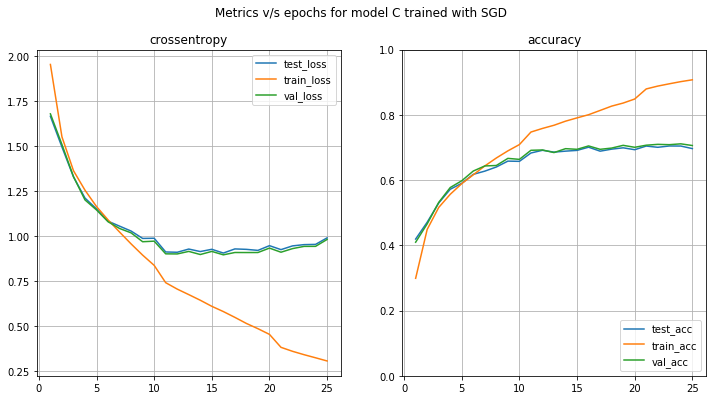

In [45]:
plot_errors(separate_metrics(train_history_c.history),
           name="model C trained with SGD")

----
**e)** Entrene la CNN definida en c) utilizando **RMSProp** durante 25 *epochs*. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de *epochs*.  
*Hint: La curva sugiere algún cambio en el modelo definido, considere ésto en cuenta para las experimentaciones futuras.*

In [ ]:
model = model_c()
model.compile(optimizer=rms_opt,loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

train_history_e = model.fit(x_tr,y_tr,batch_size=BATCH_SIZE,epochs=EPOCHS,
    callbacks=[vloss_cb,tloss_cb])

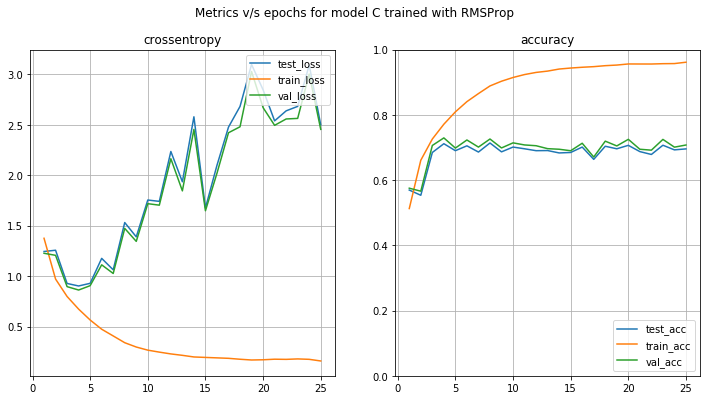

In [44]:
plot_errors(separate_metrics(train_history_e.history),
           name="model C trained with RMSProp")

> Claramete se produce *overfitting* muy rápido (aproximadamente en la epoch 5).

> Notable que este efecto se magnificó con RMSprop.

> Para resolver este problema de overfitting se agregará *batch normalization* en todas las capas. Aun es un tema de discusión si colocarla antes o después de la activación, en este caso se colocará antes.

In [15]:
def model_e2():
    inlayer = keras.layers.Input(shape=x_tr.shape[1:])
    #
    front = keras.layers.Conv2D(64,(3,3),padding='same')(inlayer)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('relu')(front)
    front = keras.layers.MaxPooling2D(pool_size=(2,2))(front)
    #
    front = keras.layers.Conv2D(64,(3,3),padding='same')(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('relu')(front)
    front = keras.layers.MaxPooling2D(pool_size=(2,2))(front)
    #
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(512)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('relu')(front)
    front = keras.layers.Dense(10)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('softmax')(front)
    #
    model = keras.models.Model(inputs=inlayer,outputs=front)
    return model

In [ ]:
model = model_e2()
model.compile(optimizer=rms_opt,loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

train_history_e2 = model.fit(x_tr,y_tr,batch_size=BATCH_SIZE,epochs=EPOCHS,
    callbacks=[vloss_cb,tloss_cb])

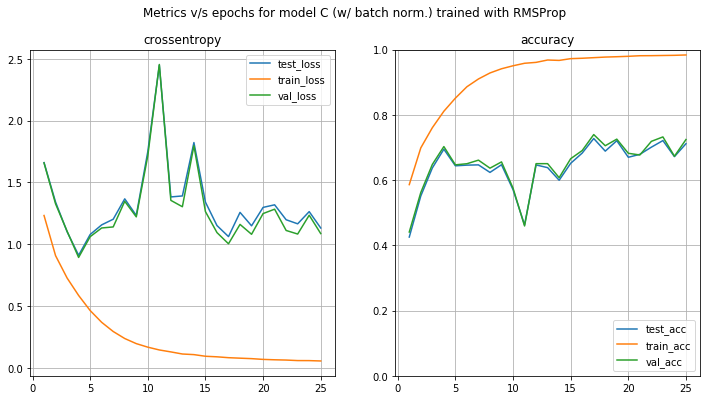

In [22]:
plot_errors(separate_metrics(train_history_e2.history),
           name="model C (w/ batch norm.) trained with RMSProp")

> Con *batch normalization* el error de entrenamiento y validación se mantuvo estable (llegando al mismo nivel de la optimización anterior) en las primeras epochs. El poner la batch normalization antes o después de la activación [está en debate](https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras). En este caso se colocó antes de la activación.

----
**f)** Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entrene durante sólo 15-20 *epochs*.

In [27]:
def model_f(deep=True,kernel=(3,3)):
    inlayer = keras.layers.Input(shape=x_tr.shape[1:])
    #
    front = keras.layers.Conv2D(64,kernel,padding='same')(inlayer)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('relu')(front)
    front = keras.layers.MaxPooling2D(pool_size=(2,2))(front)
    #
    if deep:
        front = keras.layers.Conv2D(64,kernel,padding='same')(front)
        front = keras.layers.BatchNormalization(axis=-1)(front)
        front = keras.layers.Activation('relu')(front)
        front = keras.layers.MaxPooling2D(pool_size=(2,2))(front)
    #
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(512)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('relu')(front)
    front = keras.layers.Dense(10)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('softmax')(front)
    #
    model = keras.models.Model(inputs=inlayer,outputs=front)
    return model

In [ ]:
KERNELS = [(2,2),(3,3),(4,4),(5,5)]
EPOCHS_2 = 20

train_history_f = []

for deep in (False,True):
    train_history_f.append([])
    for kern in KERNELS:
        model = model_f(deep=deep,kernel=kern)
        model.compile(optimizer=rms_opt,loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])
        history = model.fit(x_tr,y_tr,batch_size=BATCH_SIZE,epochs=EPOCHS_2,
            callbacks=[vloss_cb,tloss_cb])
        train_history_f[deep].append(history)

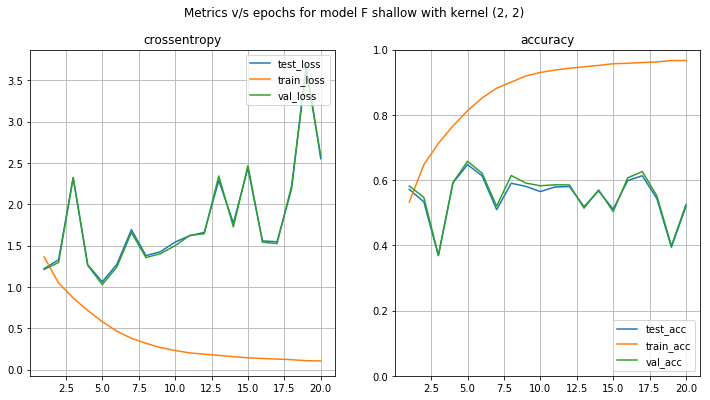

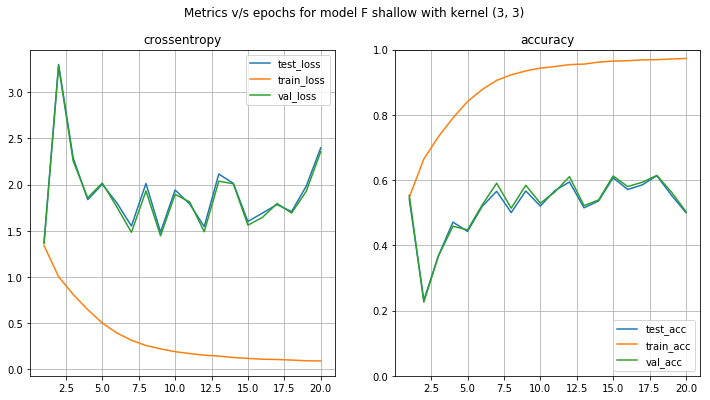

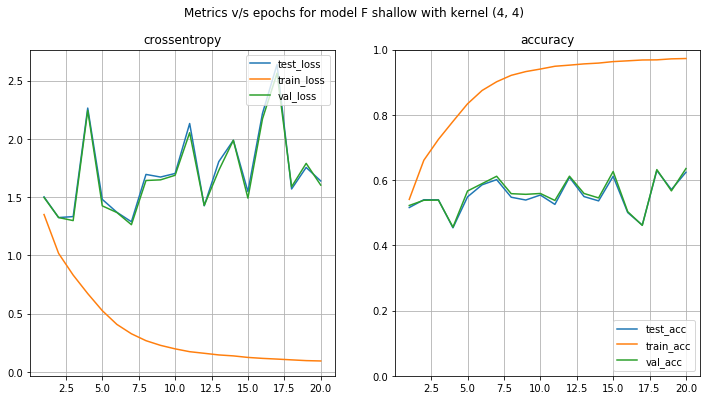

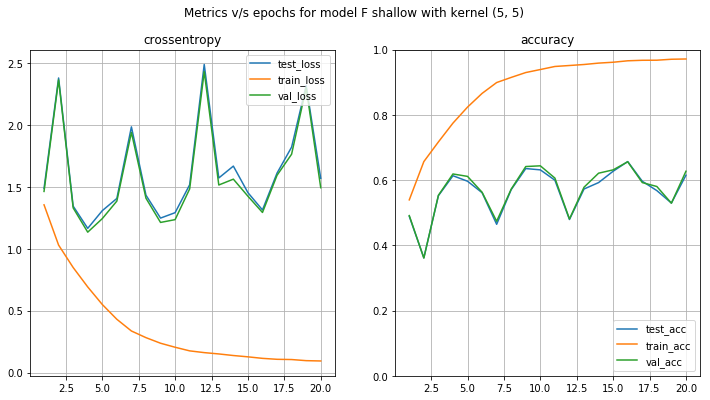

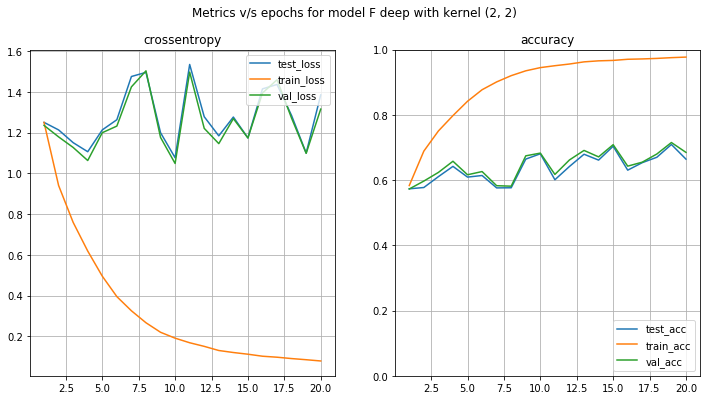

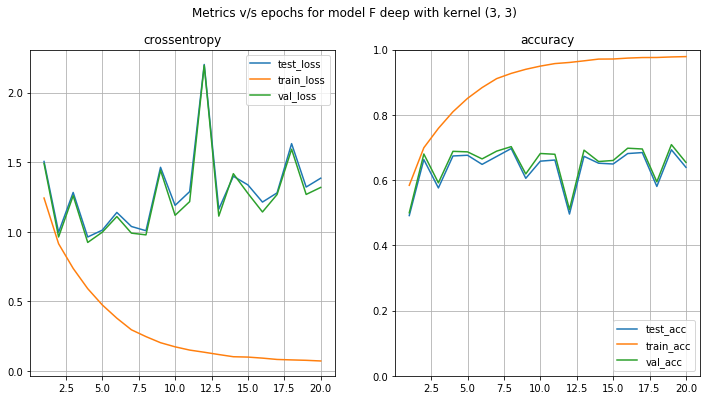

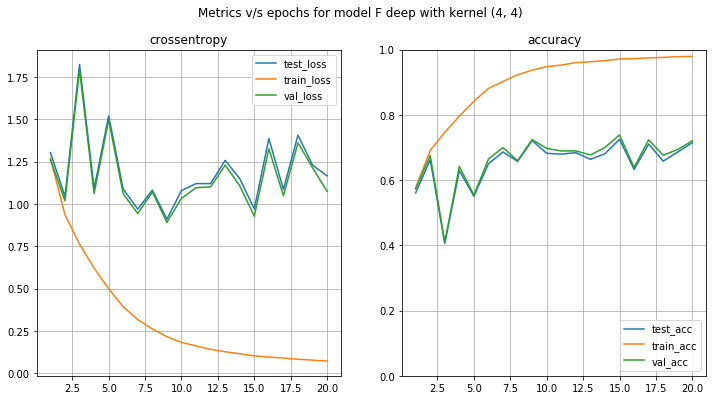

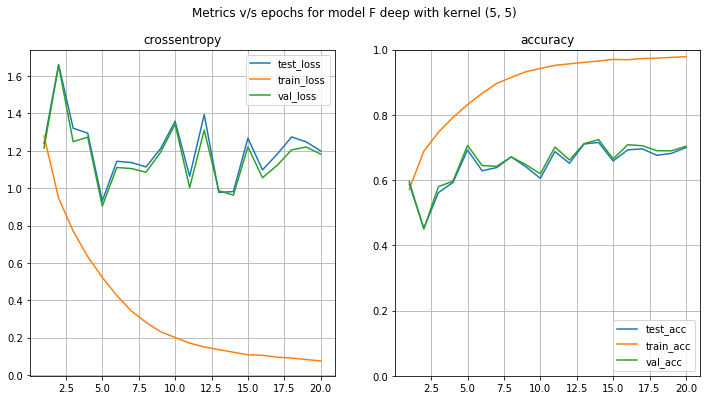

In [33]:
DEEP_NAMES = ["shallow","deep"]

for deep in (False,True):
    for i in range(len(KERNELS)):
        plot_errors(separate_metrics(train_history_f[deep][i].history),
           name="model F %s with kernel %s"%(DEEP_NAMES[deep],KERNELS[i]))

                 net   best_epoch   best_acc   last_acc  best_loss  last_loss
         2x2_shallow            5    0.64740    0.51930    1.06144    2.55077
         3x3_shallow           18    0.61340    0.50020    1.70816    2.39758
         4x4_shallow           18    0.62950    0.62410    1.56966    1.63829
         5x5_shallow           16    0.65680    0.61500    1.31388    1.56926
            2x2_deep           19    0.70920    0.66430    1.09956    1.38506
            3x3_deep            8    0.69680    0.63910    1.00797    1.38520
            4x4_deep           15    0.72490    0.71440    0.96967    1.16496
            5x5_deep           14    0.71550    0.69980    0.98142    1.19934


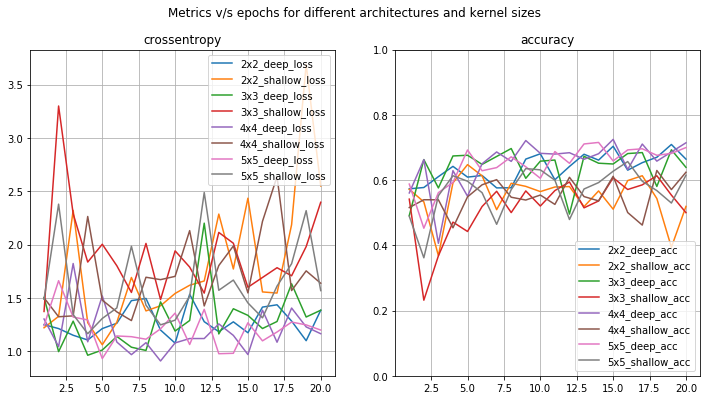

In [43]:
print("%20s %12s %10s %10s %10s %10s"%(
    "net","best_epoch","best_acc","last_acc","best_loss","last_loss"))

finals = {}
for deep in (False,True):
    for i in range(len(KERNELS)):
        metrics = separate_metrics(train_history_f[deep][i].history)
        name = '%dx%d_%s'%(KERNELS[i][0],KERNELS[i][1],DEEP_NAMES[deep])
        finals[name+'_loss'] = metrics['test_loss']
        finals[name+'_acc'] = metrics['test_acc']
        epochs_t = np.argmax(metrics['test_acc'])+1
        acc = metrics['test_acc'][epochs_t-1]
        loss = metrics['test_loss'][epochs_t-1]
        last_acc = metrics['test_acc'][-1]
        last_loss = metrics['test_loss'][-1]
        print("%20s %12d %10.5f %10.5f %10.5f %10.5f"%(
            name,epochs_t,acc,last_acc,loss,last_loss))
plot_errors(finals,name="different architectures and kernel sizes")

> Con RMSProp, alta varianza, pero notablemente error de validación similar a error de testing.

----
**g)** Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para la primera capa convolucional y 128 para la segunda (o 64 filtros para las primeras 2 capas convolucionales y 128 para las dos últimas).  

Reflexione sobre qué le parece más sensato: ¿qué estructura permite un mejor desempeño y/o extracción de atributos de interés?¿es aconsejable mantener el tamaño de los filtros usados anteriormente (pregunta anterior)? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera?  

**Hint:** con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráfique los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [16]:
def model_g(double=False):
    inlayer = keras.layers.Input(shape=x_tr.shape[1:])
    front = inlayer
    #
    for n_filters in (64,128):
        for _ in range(1+double):
            front = keras.layers.Conv2D(n_filters,(3,3),padding='same')(front)
            front = keras.layers.BatchNormalization(axis=-1)(front)
            front = keras.layers.Activation('relu')(front)
        front = keras.layers.MaxPooling2D(pool_size=(2,2))(front)
    #
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(512)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('relu')(front)
    front = keras.layers.Dense(10)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('softmax')(front)
    #
    model = keras.models.Model(inputs=inlayer,outputs=front)
    return model

In [ ]:
EPOCHS_3 = 20
BATCH_SIZE_2 = 64

train_history_g = []

for double in (False,True):
    model = model_g(double=double)
    model.compile(optimizer=rms_opt,loss='categorical_crossentropy',
        metrics=['categorical_accuracy'])
    history = model.fit(x_tr,y_tr,batch_size=BATCH_SIZE_2,epochs=EPOCHS_3,
        callbacks=[vloss_cb,tloss_cb])
    train_history_g.append(history)

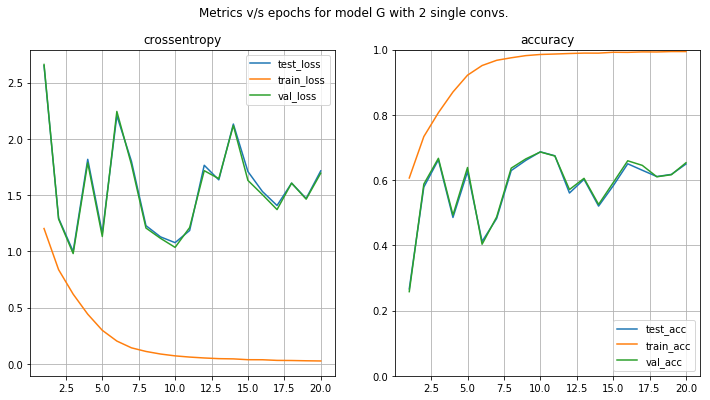

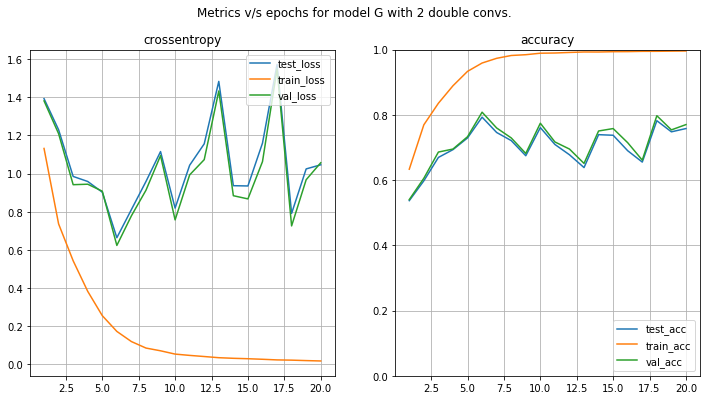

In [30]:
for double in (False,True):
    plot_errors(separate_metrics(train_history_g[double].history),
       name="model G with 2 %s convs."%("double" if double else "single"))

                 net   best_epoch   best_acc   last_acc  best_loss  last_loss
              cpcpff           10    0.68670    0.64930    1.07710    1.71515
            ccpccpff            6    0.79300    0.75810    0.66434    1.04641


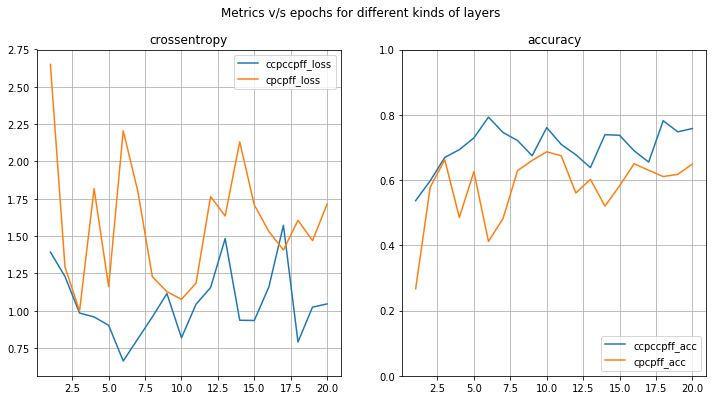

In [31]:
print("%20s %12s %10s %10s %10s %10s"%(
    "net","best_epoch","best_acc","last_acc","best_loss","last_loss"))

finals = {}
for double in (False,True):
    metrics = separate_metrics(train_history_g[double].history)
    name = ["cpcpff","ccpccpff"][double]
    finals[name+'_loss'] = metrics['test_loss']
    finals[name+'_acc'] = metrics['test_acc']
    epochs_t = np.argmax(metrics['test_acc'])+1
    acc = metrics['test_acc'][epochs_t-1]
    loss = metrics['test_loss'][epochs_t-1]
    last_acc = metrics['test_acc'][-1]
    last_loss = metrics['test_loss'][-1]
    print("%20s %12d %10.5f %10.5f %10.5f %10.5f"%(
        name,epochs_t,acc,last_acc,loss,last_loss))
plot_errors(finals,name="different kinds of layers")

**h)** Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*.  
Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [8]:
def model_h():
    inlayer = keras.layers.Input(shape=x_tr.shape[1:])
    front = inlayer
    #
    for n_filters in (64,128):
        for _ in range(2):
            front = keras.layers.Conv2D(n_filters,(3,3),padding='same')(front)
            front = keras.layers.BatchNormalization(axis=-1)(front)
            front = keras.layers.Activation('relu')(front)
        front = keras.layers.Conv2D(n_filters,(3,3),strides=(2,2))(front)
    #
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(512)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('relu')(front)
    front = keras.layers.Dense(10)(front)
    front = keras.layers.BatchNormalization(axis=-1)(front)
    front = keras.layers.Activation('softmax')(front)
    #
    model = keras.models.Model(inputs=inlayer,outputs=front)
    return model

In [9]:
model = model_h()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 64)        0         
__________

In [ ]:
EPOCHS_4 = 25
BATCH_SIZE_3 = 64

model = model_h()
model.compile(optimizer=rms_opt,loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])
train_history_h = model.fit(x_tr,y_tr,batch_size=BATCH_SIZE_3,epochs=EPOCHS_4,
    callbacks=[vloss_cb,tloss_cb])

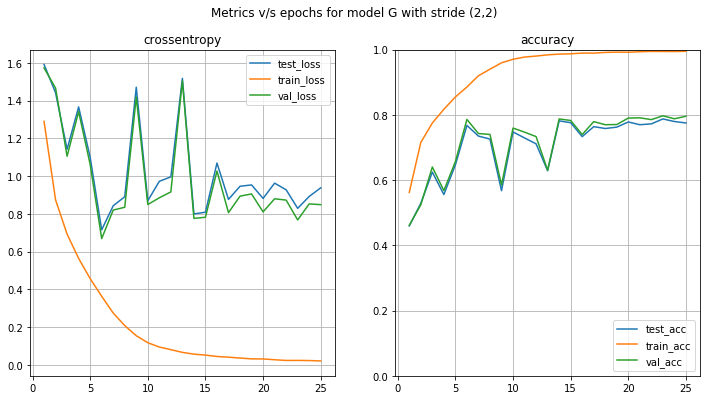

                 net   best_epoch   best_acc   last_acc  best_loss  last_loss
          convstride           23    0.78750    0.77520    0.82958    0.93838


In [16]:
metrics = separate_metrics(train_history_h.history)
plot_errors(metrics,name="model G with stride (2,2)")

print("%20s %12s %10s %10s %10s %10s"%(
    "net","best_epoch","best_acc","last_acc","best_loss","last_loss"))
epochs_t = np.argmax(metrics['test_acc'])+1
acc = metrics['test_acc'][epochs_t-1]
loss = metrics['test_loss'][epochs_t-1]
last_acc = metrics['test_acc'][-1]
last_loss = metrics['test_loss'][-1]
print("%20s %12d %10.5f %10.5f %10.5f %10.5f"%(
    "convstride",epochs_t,acc,last_acc,loss,last_loss))

**i)** Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique por qué este procedimiento podrı́a ayudar a mejorar el modelo y el por qué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.
```python
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)
model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=x_train.shape[0]// batch_size, epochs=epochs,validation_data=(x_test, y_test))
```

> **j)** Para una comparación del desempeño de la red neuronal, pre-procese el dataset de CIFAR-10 y calcule los descriptores manuales SIFT, para un mejor entendimiento de éstos consulte:  https://ianlondon.github.io/blog/how-to-sift-opencv/ y https://docs.opencv.org/3.4.3/da/df5/tutorial_py_sift_intro.html. Como se genera un descriptor de 128 dimensiones para cada *keypoint* comprima esta información de alguna manera, comente sobre la operación.

> Es necesario instalar *OpenCV* para realizar el cálculo de este descriptor.  
```python
!pip install opencv-python==3.1 opencv-contrib-python==3.4.2.16
```
  

>```python
import cv2
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray
def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)
cifar_sift = calculate_sift(X)
```
*Recuerde escalar los datos antes de entregárselos al modelo*

> **j.1)** Visualice los *keypoint* para una mejor comprensión visual de lo que son los descriptores manuales en alguna imagen aleatoria.
```python
sample_image = X[sample_index]
gray_sample_image = pre_process(sample_image)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray_sample_image, None)
"""draw and plot"""
img=cv2.drawKeypoints(gray_sample_image,kp,sample_image)
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()
```

> Entrene una red neuronal densa (la misma que sigue a las capas convoluciones definidas en los modelos previos), compare el desempeño de la red con el modelo más básico (o de peor desempeño) y el modelo de mejor desempeño obtenido hasta este punto. Comente sobre el entrenamiento (error y tiempos de ejecución) y resultados.


> **k)** Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine los pares de objetos (por ejemplo “camiones” con “autos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

> **l)** Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento. Repita el proceso para los pesos de la última capa convolucional; Comente y compare con los descriptores SIFT.

CONCLUSION

softmax refleja bastante bien la accuracy
batch normalization impide un batch size grande (igual que softmax si hay muchas clases)
raro que el error varíe tanto ¿Será culpa de rmsProp?